In [1]:
import numpy as np
import math
import  re
import time
from sklearn.model_selection import KFold
from scipy.sparse import csr_matrix
from scipy.sparse import csc_matrix
from scipy.sparse import coo_matrix
from scipy.sparse import lil_matrix
import time
import math
from tqdm import tqdm_notebook 
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
from IPython import display

%matplotlib inline

 Функция foo_Y_v(...) возвращает $\sum\limits_{i=1}^n { \sum\limits_{j=i+ 1}^n { ( v_i, v_j) x_i x_j} }$

$S = \sum\limits_{j=1}^n {v_{j,f} x_j}$

In [2]:
def foo_Y_v(X,S,V,N):
    Sum = S.power(2).sum(axis = 1) - (X.power(2)*V.power(2)).sum(axis = 1) #((X.power(2))*V[:,f])
    return Sum

def foo_S(S,X,V):
    for f in range(k):
        S[:,f] = (X * V[:,f])  
    return S



# Градиенты

In [3]:

def grad_descent_W(X,dy, W, lyambda,n): 
    Wnew = W  + 2* lyambda * (X.T*dy) / n #np.dot(X.T,dy)/N
    return Wnew

# gradient for V[:,f], v - column V[:,f] 
def gradient_V (X,v,S):
    
    grad = X.multiply(S) - (X.power(2)).multiply(v.T) #S - vector S[:,f], v - vector
    return grad
    
def grad_descent_V(X, dy,V, S, lyambda):
    #print('1',V[:,f].shape, (g))
    Vnew = V + 2 * lyambda * (gradient_V(X, V, S).T*dy) /nfeat  
    #print(Vnew.shape) 
    return Vnew


# RMSE, $R^2$

In [4]:
def foo_RMSE(Yt, Ypr):
    dy = Yt-Ypr
    s = np.power(dy,2).sum()
    rmse = math.sqrt( s  / Yt.shape[0] )
    return rmse


def foo_R2(Yt,Ypr):
    Ey = Yt.mean()
    r2 = 1 - np.sum(np.power(Ypr-Yt,2)) / np.sum(np.power((Yt - Ey),2))
    return r2

# Данные

In [5]:
NumberCustomers = 480189
NumberMovies = 17770 
f = open('combined_data_1.txt','r')
d = dict()
n = -1 # col' number  (X' number of line)
value = -1 #new CustomerID
row = []
col = []
ratings = []
start = time.time()

for line in tqdm_notebook(f):
    
    result = re.match(r'\d+:',line)
    if result is not None:
        MovieID = int(re.match(r'\d+',result.group(0)).group(0))       
    else:
        if MovieID==3000:
            break
        SplitLine= re.split(r',',line,maxsplit=2)
        KeyCustomerID = int(SplitLine[0])
        if KeyCustomerID in d:
            #search value by key
            CustomerID = d[KeyCustomerID]     
        else:
            #add (key, value)
            value+=1
            d.update([(KeyCustomerID,value)])
            CustomerID = value    
        Rating = int(SplitLine[1])
        n+=1
        row.append(CustomerID)
        col.append(n)
        row.append(NumberCustomers + MovieID)
        col.append(n)
        ratings.append(Rating)
        
data = np.ones([len(row)])
X = coo_matrix((data, (np.array(col), np.array(row))),dtype=np.int8) 
N = X.shape[0]
Y = csr_matrix(np.array(ratings).reshape(N,1))
Y = Y.todense()
#X,Xtest, Y, Ytest = train_test_split(X,Y, test_size=0.2)
end = time.time()
print( 'Time: ', (end - start))


A Jupyter Widget

Time:  441.0612750053406


In [6]:
del d
del col
del row
del data
X

<15543024x483189 sparse matrix of type '<class 'numpy.int8'>'
	with 31086048 stored elements in COOrdinate format>

# Инициализация

In [26]:
Stage = 1000 # 
batch_size = 20000
k = 2
test_part = 0.3

train_size = int(batch_size*(1-test_part))
test_size = int(batch_size*test_part)
nstep = 0

# learnig steps of each batch
Nsteps = 20
lyambda_W = 2e-1
lyambda_V = 2e-3
nfeat = X.shape[1]


cost = []
RMSEtrain = []
RMSEtest = []
R2train = []
R2test = []
time_list=[]


# Преобразование в sparse_matrix

In [8]:
X = X.tocsr()

In [27]:
start = time.time()
#X = X.tocsr()
W = csr_matrix(np.ones(nfeat).reshape(nfeat,1)) 
V = csr_matrix(np.ones((nfeat,k)))
S = lil_matrix(np.ones((train_size,k)))# lil
Vnew = V.copy()

end = time.time()
print("Total time: ", time.time()-start)

Total time:  0.1939096450805664


# Обучение

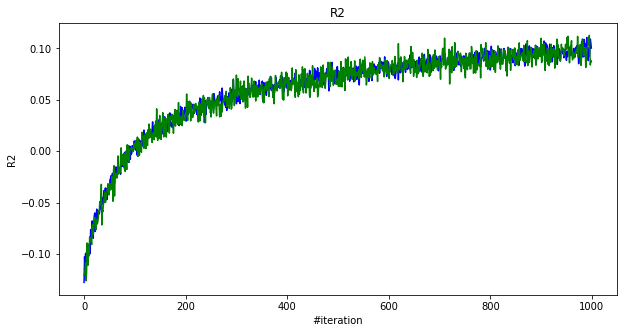

R2test: 0.087182


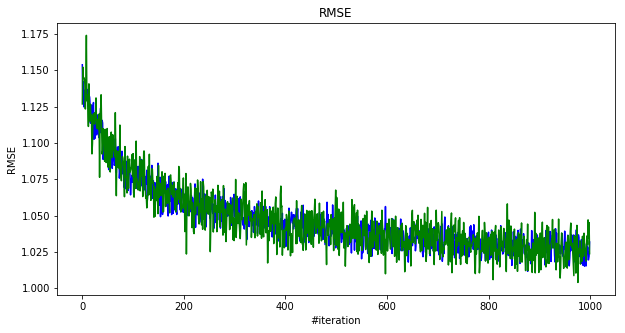

RMSE2test: 1.023765
Time: 12.156261

Total time:  12967.904564380646


In [28]:

start = time.time()
for stage in tqdm_notebook(range(Stage)):
    print('Stage № ', stage, "\n" )
    batch_indexes = np.random.choice(N, batch_size)
    
    Xbatch = X[batch_indexes]
    Ybatch = Y[batch_indexes]
    #Xbatch = X
    #Ybatch = Y
    start_stage = time.time()
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xbatch,Ybatch, test_size = test_part) 
    nstep = 0
    while True:
            nstep +=1
            
            S = foo_S(S,Xtrain,V)
            Ypred = Xtrain@W + 1/2 * foo_Y_v(Xtrain, S,V,train_size)
            dy = Ytrain - Ypred
            #print(Ytrain[:4], Ypred[:4])
            Wnew = grad_descent_W(Xtrain,dy, W, lyambda_W/math.sqrt(nstep),train_size)
            
            for f in range(k):
                Vnew[:,f] = grad_descent_V( Xtrain, dy,V[:,f], S[:,f],lyambda_V/math.sqrt(nstep))
         
            W = Wnew
            V = Vnew

            
            if (nstep>Nsteps):
                    break
        
    Ypred = Xtrain@W + 1/2 * foo_Y_v(Xtrain, foo_S(S,Xtrain,V),V,train_size)
    cost.append((np.power(dy,2).sum())/train_size)
     
    rmse = foo_RMSE(Ytrain,Ypred)
    RMSEtrain.append(rmse)
    #print ("RMSE for train: ",rmse) 
        
    r2 = foo_R2(Ytrain,Ypred)
    R2train.append(r2)
    #print("R2 for train: ",r2 , "\n")
        
     #for test   
    Stest = lil_matrix(np.ones((Xtest.shape[0],k)))
    Stest = foo_S(Stest,Xtest,V)
    Ypred_test = Xtest*W + 1/2 * foo_Y_v(Xtest, Stest,V,Xtest.shape[0])
        
    rmse = foo_RMSE(Ytest,Ypred_test)
    RMSEtest.append(rmse)
    #print ("RMSE for test: ",rmse ) 
        
    r2 = foo_R2(Ytest,Ypred_test)
    R2test.append(r2)
    #print("R2 for test: ",r2,"\n")
    
    end = time.time()
    time_list.append(end - start_stage)
    #print( 'Time: ', (end - start_stage),'\n')
    
    display.clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.title("R2")
    plt.xlabel("#iteration")
    plt.ylabel("R2")
    plt.plot( R2train, 'b',label="train")
    plt.plot( R2test, 'g',label="test")
    plt.show()
    
    print('R2test: %f' % r2)
    
    plt.figure(figsize=(10, 5))
    plt.title("RMSE")
    plt.xlabel("#iteration")
    plt.ylabel("RMSE")
    plt.plot(RMSEtrain, 'b', label='train')
    plt.plot(RMSEtest, 'g', label = 'test')
    #plt.plot(cost,'b')
    plt.show()
    print('RMSE2test: %f' % rmse)

    print('Time: %f' % (time.time() - start_stage))
    
print("Total time: ", time.time()-start)

# Результаты


In [56]:
print( "Cреднее значение R2train на последних %i стадий:" %20 ,  np.array(R2train[980:]).sum()/20)
print( "Cреднее значение R2test на финальных  %i стадиях:" %20 ,  np.array(R2test[980:]).sum()/20)
print( "Cреднее значение RMSEtrain на последних %i стадий:" %20 , np.array(RMSEtrain[980:]).sum()/20)
print( "Cреднее значение RMSEtest на финальных  %i стадиях:" %20 , np.array(RMSEtest[980:]).sum()/20)

Cреднее значение R2train на последних 20 стадий: 0.1002457241
Cреднее значение R2test на финальных  20 стадиях: 0.0975440273168
Cреднее значение RMSEtrain на последних 20 стадий: 1.0242074111
Cреднее значение RMSEtest на финальных  20 стадиях: 1.02931831237
